In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import pymongo
from collections import Counter
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA

In [49]:
def create_dataframe(recipes, cutoff=2):
    recipe_ids = _get_recipe_ids(recipes)
    common_ingredients = _get_common_ingredients(recipes, cutoff=cutoff)
    df = pd.DataFrame(columns=common_ingredients, index=recipe_ids).fillna(0)
    unknown_servings = []
    for recipe in recipes:
        idx = recipe['id']
        servings = recipe['directions']['servings']
        if not servings:
            unknown_servings.append(recipe)
            #print('Servings missing')
            continue
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    # Determine approx servings for recipes where it is not specified
    for recipe in unknown_servings:
        servings = _approximate_servings(recipe, df)
        recipe['directions']['approx_servings'] = servings
    # Apply approx servings to recipes and insert data into dataframe
    for recipe in unknown_servings:
        servings = recipe['directions']['approx_servings']
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    return df

def _get_recipe_ids(recipes):
    recipe_ids = []
    for recipe in recipes:
        recipe_ids.append(recipe['id'])
    return recipe_ids

def _approximate_servings(recipe, df):
    recipe_qtys = []
    df_means = []
    for ing, qty in recipe['ingredients'].items():
        if ing in df.columns:
            recipe_qtys.append(qty['normalized_qty'])
            ing_vals = df[df[ing] != 0][ing]
            df_means.append(np.mean(ing_vals))
    qtys_array = np.array(recipe_qtys)
    df_means_array = np.array(df_means)
    count = 1
    while True:
        err = np.mean(abs(qtys_array/count - df_means_array)) * count
        next_err = np.mean(abs(qtys_array/(count+1) - df_means_array)) * (count+1)
        if next_err > err:
            return count
        count += 1
        err = next_err
        
def _get_common_ingredients(recipes, cutoff=2):
    ingredients = Counter()
    for recipe in recipes:
        for ing in recipe['ingredients'].keys():
            ingredients[ing] += 1
    #print('Number of unique ingredients :', len(ingredients))
    common_ingredients = []
    for item, count in ingredients.most_common():
        if count >= cutoff:
            common_ingredients.append(item)
    #print('Number of common ingredients :', len(common_ingredients))
    return common_ingredients

def get_label_names(recipes, cat_lvl=2):
    labels = []
    key = 'lvl_{}'.format(cat_lvl)
    for recipe in recipes:
        labels.append(recipe['category'][key])
    return labels

def get_label_numbers(label_names, limit=None):
    ordered_names = [key for key, val in Counter(label_names).most_common()]
    label_nums = [ordered_names.index(label) for label in label_names]
    if not limit:
        return label_nums
    else:
        return [num if num < limit-1 else limit-1 for num in label_nums]
    
def scale_dataframe(df):
    means = np.mean(df, axis=0)
    stds = np.std(df, axis=0)
    return (df - means) / stds, means, stds

In [6]:
mc = pymongo.MongoClient()
db = mc['allrecipes']
recipes_coll = db['recipes']

In [8]:
cursor = recipes_coll.find()
chili_recipes = []
for recipe in cursor:
    if recipe['category']['lvl_2'] == 'Chili':
        chili_recipes.append(recipe)

In [15]:
chili_df = create_dataframe(chili_recipes, cutoff=5)
scaled_df, means, stds = scale_dataframe(chili_df)

In [125]:
X = chili_df - means

In [28]:
pca_20 = PCA(n_components=20)

In [126]:
pca_20.fit(X)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [84]:
def scree_plot(ax, pca, n_components_to_plot=20, title=None):
    """Make a scree plot showing the variance explained (i.e. variance
    of the projections) for the principal components in a fit sklearn
    PCA object.
    
    Parameters
    ----------
    ax: matplotlib.axis object
      The axis to make the scree plot on.
      
    pca: sklearn.decomposition.PCA object.
      A fit PCA object.
      
    n_components_to_plot: int
      The number of principal components to display in the scree plot.
      
    title: str
      A title for the scree plot.
    """
    num_components = pca.n_components_
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    ax.plot(ind, vals, color='blue')
    ax.scatter(ind, vals, color='blue', s=50)

    for i in range(num_components):
        ax.annotate(r"{:2.2f}%".format(vals[i]*100), 
           (ind[i]+0.2, vals[i]+0.005), 
           va="bottom", 
           ha="center", 
           fontsize=12)

    ax.set_xticklabels(ind, fontsize=12)
    ax.set_ylim(0, max(vals) + 0.05)
    ax.set_xlim(0 - 0.45, n_components_to_plot + 0.45)
    ax.set_xlabel("Principal Component", fontsize=12)
    ax.set_ylabel("Variance Explained", fontsize=12)
    if title is not None:
        ax.set_title(title, fontsize=16)

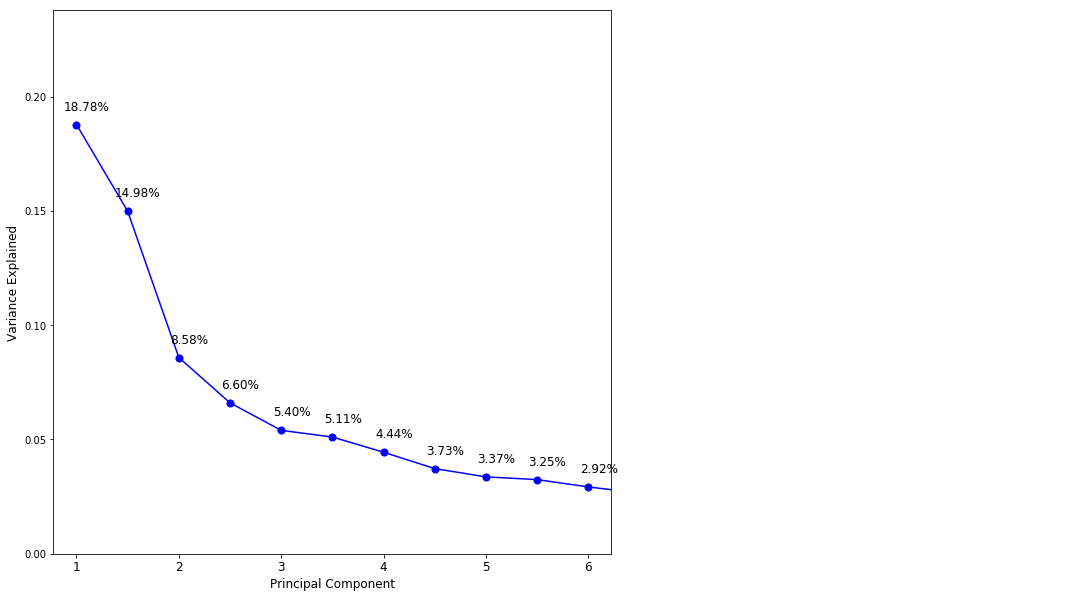

In [122]:
fig, ax = plt.subplots(figsize=(10,10))
scree_plot(ax, pca_20,n_components_to_plot=10)

In [50]:
labels = get_label_names(chili_recipes, 3)
get_label_numbers(labels, limit=4)

[1,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 3,
 3,
 1,
 1,
 2,
 2,
 3,
 3,
 1,
 3,
 0,
 2,
 2,
 3,
 2,
 3,
 3,
 1,
 3,
 3,
 0,
 3,
 2,
 0,
 3,
 3,
 3,
 3,
 2,
 3,
 2,
 3,
 1,
 1,
 0,
 3,
 0,
 3,
 2,
 1,
 1,
 0,
 0,
 0,
 3,
 2,
 0,
 3,
 0,
 3,
 0,
 1,
 3,
 3,
 1,
 0,
 0,
 2,
 2,
 0,
 0,
 3,
 0,
 1,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 0,
 3,
 0,
 1,
 3,
 0,
 0,
 2,
 3,
 3,
 1,
 1,
 3,
 3,
 2,
 1,
 2,
 2,
 3,
 3,
 3,
 0,
 0,
 3,
 3,
 0,
 0,
 1,
 0,
 1,
 3,
 0,
 2,
 0,
 1,
 3,
 0,
 3,
 3,
 1,
 0,
 3,
 1,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 0,
 2,
 3,
 0,
 3,
 3,
 0,
 0,
 1,
 1,
 3,
 0,
 2,
 0,
 3,
 0,
 2,
 0,
 0,
 3,
 3,
 3,
 0,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 0,
 2,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 3,
 3,
 1,
 3,
 0,
 3,
 0,
 0,
 1,
 0,
 3,
 3,
 1,
 3,
 3,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 3,
 1,
 3,
 0,
 2,
 3,
 0,
 2,
 0,
 0,
 1,
 1]

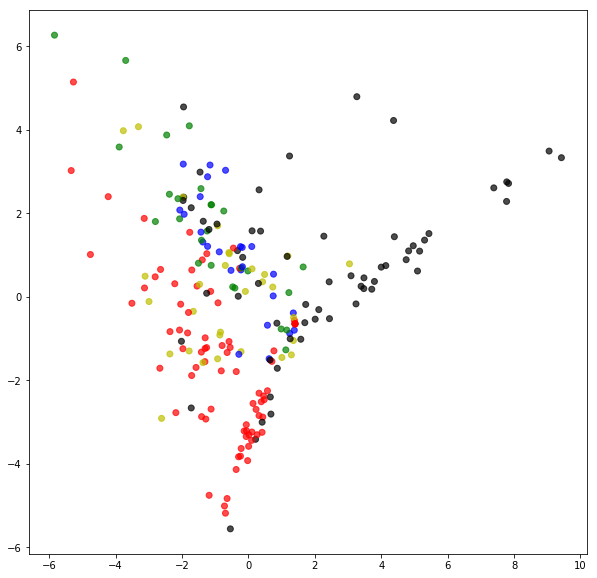

In [127]:
chili_2D = X.values @ pca_20.components_[:2].T
c = np.array(['r','y','g','b','k'])[get_label_numbers(labels, limit=5)]
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(chili_2D[:,0], chili_2D[:,1], color=c, alpha=.7)

In [67]:
pca_20.components_[0] * stds + means

onion                         1.110214
chili powder                  0.080241
cumin                         0.037708
tomato                        1.828382
garlic                        0.128845
beef                          0.891477
bell pepper                   0.433243
salt                          0.009137
oregano                       0.017186
kidney beans                  0.716243
black pepper                  0.005286
tomato sauce                  0.420640
water                         0.454643
cayenne pepper                0.007039
olive oil                     0.036398
black beans                   0.615313
tomato paste                  0.101625
vegetable oil                 0.025486
jalapeno pepper               0.050761
garlic powder                 0.004485
chicken broth                 0.996669
paprika                       0.003707
pinto beans                   0.278567
celery                        0.048268
chicken                       1.064036
red pepper flake         

In [158]:
cursor = recipes_coll.find()
beef_recipes = []
for recipe in cursor:
    if recipe['category']['lvl_3'] == 'Beef Chili':
        beef_recipes.append(recipe)

In [170]:
beef_df = create_dataframe(beef_recipes,cutoff=5)
beef_scaled, beef_means, beef_stds = scale_dataframe(beef_df)

In [162]:
beef_df.shape

(79, 37)

In [180]:
beef_pca = PCA(n_components=10).fit(beef_df - beef_means)

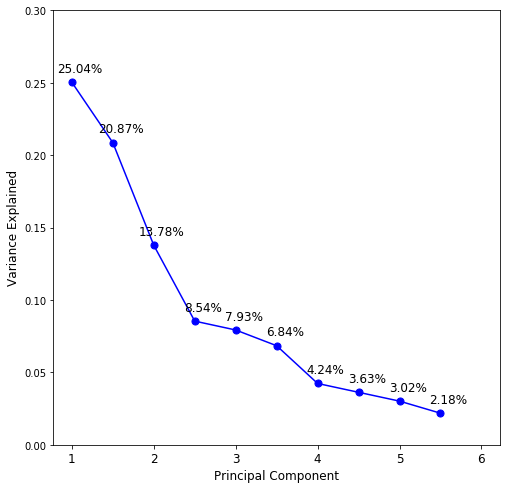

In [181]:
fig, ax = plt.subplots(figsize=(8,8))
scree_plot(ax, beef_pca,n_components_to_plot=10)

In [182]:
beef_2d = beef_df @ beef_pca.components_[:2].T
beef_2d

,0,1
26462,0.058788,2.426443
15386,0.253500,2.430305
16188,1.726646,3.788376
13067,1.525332,7.405800
24406,0.758598,0.344121
23118,0.047177,3.072148
80760,-0.180260,3.349320
25722,3.022538,3.442454
25686,4.214622,2.942851
108455,2.284726,-0.616923


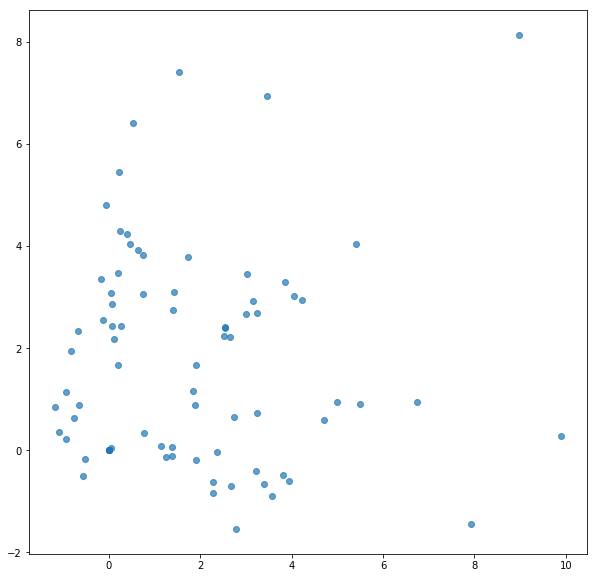

In [183]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(beef_2d.iloc[:,0], beef_2d.iloc[:,1], alpha=.7)

In [184]:
beef_pcs = pd.DataFrame(index=beef_means.index)

In [187]:
beef_pcs['1st'] = beef_pca.components_[0] + beef_means
beef_pcs['2nd'] = beef_pca.components_[1] + beef_means
beef_pcs['3rd'] = beef_pca.components_[2] + beef_means

In [188]:
beef_pcs

,1st,2nd,3rd
beef,2.737781,3.003187,3.741509
onion,1.042069,0.966196,1.082693
chili powder,0.104063,0.110746,0.120905
kidney beans,2.144258,2.824277,1.818955
tomato,2.852902,1.701765,2.099960
garlic,0.105286,0.085844,0.084953
cumin,0.023807,0.023904,0.023923
bell pepper,0.363339,0.413404,0.403675
tomato sauce,0.771963,0.960033,1.162562
salt,0.011459,0.010536,0.011765


In [196]:
pc1 = pd.Series(beef_pca.components_[0], index=beef_means.index)
pc1[abs(pc1) > beef_means/5]

tomato            0.937406
garlic            0.026693
oregano           0.003675
white sugar       0.008259
olive oil         0.006073
garlic powder    -0.000840
black beans       0.074149
parsley          -0.000905
cheddar cheese   -0.021089
tomato juice     -0.132239
dtype: float64

In [197]:
pc2 = pd.Series(beef_pca.components_[1], index=beef_means.index)
pc2[abs(pc2) > beef_means/5]

kidney beans          0.930274
tomato paste          0.038638
pinto beans          -0.181550
celery                0.026417
red pepper flake     -0.001723
paprika              -0.001123
basil                 0.002379
chili beans          -0.079986
black beans          -0.076278
brown sugar           0.005008
cheddar cheese        0.021156
habanero pepper      -0.000552
ranchstyle beans     -0.086686
green chile pepper    0.009191
dtype: float64